# The randomised block design

## 1. Introduction

The principal disadvantage of the completely randomised design (CRD) appears if it used in an experiment with factors on an experimental site which is not uniform. A particular factor can be assigned by chance to locations which have special properties and a false conclusion may be made about the response to the factors. 

This disadvantage can be overcome by using blocking. If there is a systemic variation in the experimental conditions across the experimental site with the existence of a gradient of experimental conditions, we can divide the experimental area into blocks at right angles to the gradient. For example, to compare five factors using six replications per factor, we could form six blocks each consisting of five equal sized experimental area. 

This experimental design is called the **randomised block design** (RBD), sometimes the *randomised complete block design* since each block contains the complete set of factors. 

As each factor occurs once per block, factors can be compared within blocks, so block-to-block (gradient) does not affect factor comparisons. The advantage of RBD over CRD depends on the within-block variation being smaller than block-to-block variation. Ideally, on should have acquired knowledge of the experimental site in order to ensure that blocks are positioned correctly. If blocks are formed without using information on experimental site variation, variation within blocks could be greater than variation between blocks. In this case blocking will be unsuccessful and factors will be compared with less precision than if a CRD had been used. If the site is uniform, a CRD should be used because the loss of the residual degrees of freedom due to blocks will not be compensated by the reduction of error variance.

Disadvantagesof blocking are:
* missing values cause differences between factors to be partly due to block differences
* if the number of factors is important, finding block that are big enough to accomodate all factors can be impossible (in this case use the incomplete block design)

## 2. An example with analysis ignoring blocks

Suppose we want to compare three new wheat varieties ($V_2$, $V_3$ and $V_4$) with a standard variety ($V_1$). The experimental area could be divided into three blocks each containing four plots of equal size. In practice we should use more than three blocks but we use a simplified example.

In [49]:
#import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from scipy.stats import probplot
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import t
from scipy.stats import f
from math import ceil

In [2]:
#generate pandas dataframe
df = pd.DataFrame({'V1':[7.4, 6.5, 5.6], 
                   'V2':[9.8, 6.8, 6.2], 
                   'V3':[7.3, 6.1, 6.4], 
                   'V4':[9.5, 8.0, 7.4],
                  }, 
                  index=['Block 1', 'Block 2', 'Block 3'])

print('Yields of four wheat varieties')
print(df, '\n')

#print block means
for block in df.index:
    print('Mean of {0} : {1:.2f}'.format(block, df.loc[block].mean()))
print()

#print variety means
for variety in df.columns:
    print('Mean of variety {0} : {1:.2f}'.format(variety, df[variety].mean()))

Yields of four wheat varieties
          V1   V2   V3   V4
Block 1  7.4  9.8  7.3  9.5
Block 2  6.5  6.8  6.1  8.0
Block 3  5.6  6.2  6.4  7.4 

Mean of Block 1 : 8.50
Mean of Block 2 : 6.85
Mean of Block 3 : 6.40

Mean of variety V1 : 6.50
Mean of variety V2 : 7.60
Mean of variety V3 : 6.60
Mean of variety V4 : 8.30


Yields decrease from block 1 to block 3 and this could be due to an environmental gradient at right angles to the blocks. Is there sufficient evidence to argue that the new varieties are significantly different from the standard? Let's first analyze the data ignoring blocks.

In [3]:
#F-test ignoring blocks
f_oneway(df['V1'], df['V2'], df['V3'], df['V4'])

F_onewayResult(statistic=1.4515599343185546, pvalue=0.2986889963332586)

This high p-value of 0.3 indicates that in the absence of blocking there is insufficient evidence that the new varieties perform differently from the standard variety.

## 3. The randomised block model

The procedure depends on the assumption that each result is the addition of several effects:
* actual value = overall mean + block effect + factor effect + residual
* actual value = fitted value + residual
* fitted value = overall mean + block effect + factor effect
* residual = actual value - fitted value


* block effect is estimated by : block mean - grand mean
* factor effect is estimated by : factor mean - grand mean


* the overall mean is estimated by the grand mean (GM)
* the block effect is estimated as BE = block mean - grand mean = BM - GM
* the factor effect is estimated as FE = factor mean - grand mean = FM - GM
* the fitted value predicted by the model is estimated as F = GM + BE + FE = BM + FM - GM
* the residual is the difference between the observed value V and the fitted value F. It is estimated as R = V - F = Y - BM - FM + GM

Let's perform an analysis of variance according to this model and F-tests on block and variety.

Analysis of variance
Source            df    Sum sq   Mean sq         F   p-value
Blocks             2     9.780     4.890    12.225   0.00765
Varieties          3     6.630     2.210     5.525   0.03673
Error              6     2.400     0.400
Total             11    18.810

Means
Level              N      Mean   Std dev
V1                 3     6.500     0.377
V2                 3     7.600     0.826
V3                 3     6.600     0.606
V4                 3     8.300     0.087

Shapiro-Wilk test for residuals
W = 0.9176, p-value = 0.2666


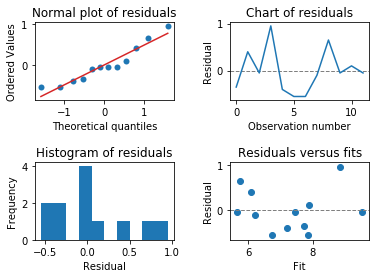

In [27]:
#ANOVA

#total experiment size
N = df.size

#number of blocks
n_b = len(df.index)

#number of factors
n_f = len(df.columns)

#total sum of squares
total_ss = df.values.flatten().var(ddof=1) * (N - 1)

#block sum of squares and mean square
block_ss = df.sum(axis=1).std() ** 2 * (n_b - 1) / n_f
block_ms = block_ss / (n_b - 1)

#factor sum of squares and mean square
factor_ss = df.sum().std() ** 2 * (n_f - 1) / n_b
factor_ms = factor_ss / (n_f - 1)

#residual sum of squares and mean square
resid_ss = total_ss - block_ss - factor_ss
resid_ms = resid_ss / (n_b - 1) / (n_f - 1)

#variety means
means = df.mean()

#variety standard deviation have to be adjusted for block effects
#we first calculate block effects by subtracting the grand mean from block means
#we then recalculate the table by subtracting the block effect from values
df_adjust = (df.T - (df.mean(axis=1) - df.values.flatten().mean())).T
std_devs = df_adjust.std()

#residual dataframe
df_resid = ((df - df.mean()).T - df.mean(axis=1)).T + df.values.flatten().mean()

#fitted dataframe
df_fitted = df - df_resid

print('Analysis of variance')
print('{0:10}{1:>10}{2:>10}{3:>10}{4:>10}{5:>10}'.format('Source', 'df', 'Sum sq', 'Mean sq', 'F', 'p-value'))
print('{0:10}{1:>10}{2:>10.3f}{3:>10.3f}{4:>10.3f}{5:>10.5f}'.format('Blocks', 
                                                                     n_b - 1, 
                                                                     block_ss, 
                                                                     block_ms, 
                                                                     block_ms / resid_ms,
                                                                     1 - f.cdf(block_ms / resid_ms, n_b - 1, (n_b-1)*(n_f-1))))
print('{0:10}{1:>10}{2:>10.3f}{3:>10.3f}{4:>10.3f}{5:>10.5f}'.format('Varieties', 
                                                                     n_f - 1, 
                                                                     factor_ss, 
                                                                     factor_ms, 
                                                                     factor_ms / resid_ms,
                                                                     1 - f.cdf(factor_ms / resid_ms, n_f - 1, (n_b-1)*(n_f-1))))
print('{0:10}{1:>10}{2:>10.3f}{3:>10.3f}'.format('Error', (n_f - 1) * (n_b - 1), resid_ss, resid_ms))
print('{0:10}{1:>10}{2:>10.3f}'.format('Total', N - 1, total_ss))
print()
print('Means')
print('{0:10}{1:>10}{2:>10}{3:>10}'.format('Level', 'N', 'Mean', 'Std dev'))
for i, variety in enumerate(df.columns):
    print('{0:10}{1:>10}{2:>10.3f}{3:>10.3f}'.format(variety, df[variety].count(), df[variety].mean(), std_devs[i]))
    
print()

#testing normality of residuals
W, pval = shapiro(df_resid.values.flatten())
print('Shapiro-Wilk test for residuals')
print('W = {0:.4f}, p-value = {1:.4f}'.format(W, pval))

#checking normality of residuals with plot
fig, axes = plt.subplots(nrows=2, ncols=2)
ax0, ax1, ax2, ax3 = axes.flatten()
qq_resid = probplot(df_resid.values.flatten(), plot=ax0)
ax0.get_lines()[0].set_markerfacecolor('C0')
ax0.get_lines()[0].set_markeredgewidth(0)
ax0.get_lines()[1].set_color('C3')
ax0.set_title('Normal plot of residuals')

ax1.axhline(0, color='grey', lw=1, linestyle='dashed')
ax1.plot(list(range(N)), df_resid.values.T.flatten())
ax1.set_xlabel('Observation number')
ax1.set_ylabel('Residual')
ax1.set_title('Chart of residuals')

ax2.hist(df_resid.values.flatten())
ax2.set_xlabel('Residual')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of residuals')

ax3.axhline(0, color='grey', lw=1, linestyle='dashed')
ax3.scatter(df_fitted.values.flatten(), df_resid.values.flatten())
ax3.set_xlabel('Fit')
ax3.set_ylabel('Residual')
ax3.set_title('Residuals versus fits')

plt.subplots_adjust(hspace=0.8, wspace=0.4)

### Confidence intervals

A 95% confidence interval for the $\mu$ is $\bar{x} \pm t_{(Rdf, \thinspace 2.5\%)} \times SEM$. In our example, $SEM$ is found by pooling the data from all factors: $$SEM = \sqrt{\frac{RMS}{r}}$$. Let's calculate these values.

In [5]:
#Levene's test to check equality of variance
print('Checking homoscedasticity :')
print(levene(df['V1'], df['V2'], df['V3'], df['V4']), '\n')

#calculate standard error of the mean
sem = np.sqrt(resid_ms / df.count()[0])

#residual degrees of freedom
Rdf = (n_b - 1) * (n_f - 1)

#critical t-values for confidence interval
crit_t = [t.ppf(0.025, Rdf), t.ppf(0.975, Rdf)]

CI = [[mean + value * sem for value in crit_t] for mean in means]

for i, level in enumerate(means.index):
    print('Confidence interval for sample {0} : {1:.3f} - {2:.3f}'.format(level, CI[i][0], CI[i][1]))

Checking homoscedasticity :
LeveneResult(statistic=0.38935574229691866, pvalue=0.7639802062200832) 

Confidence interval for sample V1 : 5.607 - 7.393
Confidence interval for sample V2 : 6.707 - 8.493
Confidence interval for sample V3 : 5.707 - 7.493
Confidence interval for sample V4 : 7.407 - 9.193


In [31]:
#putting it all together

def anova_block(df, xlabel, ylabel):
    """Perform ANOVA on an experimental design with blocking."""
    
    #total experiment size
    N = df.size

    #number of blocks
    n_b = len(df.index)

    #number of factors
    n_f = len(df.columns)

    #total sum of squares
    total_ss = df.values.flatten().var(ddof=1) * (N - 1)

    #block sum of squares and mean square
    block_ss = df.sum(axis=1).std() ** 2 * (n_b - 1) / n_f
    block_ms = block_ss / (n_b - 1)

    #factor sum of squares and mean square
    factor_ss = df.sum().std() ** 2 * (n_f - 1) / n_b
    factor_ms = factor_ss / (n_f - 1)

    #residual sum of squares and mean square
    resid_ss = total_ss - block_ss - factor_ss
    resid_ms = resid_ss / (n_b - 1) / (n_f - 1)

    #variety means
    means = df.mean()
    
    #variety standard deviation have to be adjusted for block effects
    #we first calculate block effects by subtracting the grand mean from block means
    #we then recalculate the table by subtracting the block effect from values
    df_adjust = (df.T - (df.mean(axis=1) - df.values.flatten().mean())).T
    std_devs = df_adjust.std()

    #residual dataframe
    df_resid = ((df - df.mean()).T - df.mean(axis=1)).T + df.values.flatten().mean()

    #fitted dataframe
    df_fitted = df - df_resid

    #calculate standard error of the mean
    sem = np.sqrt(resid_ms / df.count()[0])

    #residual degrees of freedom
    Rdf = (n_b - 1) * (n_f - 1)

    #critical t-values for confidence interval
    crit_t = [t.ppf(0.025, Rdf), t.ppf(0.975, Rdf)]

    CI = [[round(mean + value * sem, 3) for value in crit_t] for mean in means]
    
    print('Analysis of variance\n')
    print('{0:10}{1:>10}{2:>10}{3:>10}{4:>10}{5:>10}'.format('Source', 'df', 'Sum sq', 'Mean sq', 'F', 'p-value'))
    print('{0:10}{1:>10}{2:>10.3f}{3:>10.3f}{4:>10.3f}{5:>10.5f}'.format('Blocks', 
                                                                     n_b - 1, 
                                                                     block_ss, 
                                                                     block_ms, 
                                                                     block_ms / resid_ms,
                                                                     1 - f.cdf(block_ms / resid_ms, n_b - 1, (n_b-1)*(n_f-1))))
    print('{0:10}{1:>10}{2:>10.3f}{3:>10.3f}{4:>10.3f}{5:>10.5f}'.format('Varieties', 
                                                                     n_f - 1, 
                                                                     factor_ss, 
                                                                     factor_ms, 
                                                                     factor_ms / resid_ms,
                                                                     1 - f.cdf(factor_ms / resid_ms, n_f - 1, (n_b-1)*(n_f-1))))
    print('{0:10}{1:>10}{2:>10.3f}{3:>10.3f}'.format('Error', (n_f - 1) * (n_b - 1), resid_ss, resid_ms))
    print('{0:10}{1:>10}{2:>10.3f}'.format('Total', N - 1, total_ss))
    print()
    print('Means')
    print('{0:10}{1:>10}{2:>10}{3:>10}{4:>10}{5:>8}'.format('Level', 'N', 'Mean', 'Std dev', '', '95% CI'))
    for i, variety in enumerate(df.columns):
        print('{0:10}{1:>10}{2:>10.3f}{3:>10.3f}{4:>10} - {5:>5}'.format(variety,
                                                                df[variety].count(),
                                                                   df[variety].mean(),
                                                                   std_devs[i],
                                                                   CI[i][0],
                                                               CI[i][1]))

    print()
    
    test_levene = levene(df['V1'], df['V2'], df['V3'], df['V4'])
    print("Levene's test :")
    print('W = {0:.3f}, p-value = {1:.5f}'.format(test_levene[0], test_levene[1]))
    
    #plot data with confidence intervals
    pos = list(range(n_f))
    fig, ax = plt.subplots()
    for i, col in enumerate(df.columns):
        ax.bar(pos[i], np.mean(df[col]), zorder=3, edgecolor='k', linewidth=.5)
        ax.errorbar(pos[i], np.mean(df[col]), crit_t[0] * sem, zorder=4, c='k', capsize=5)
        
    #optimize figure style
    ax.set_xticks(pos)
    ax.tick_params(axis='x', color='white')
    ax.set_xticklabels(df.columns)
    for position in ['top', 'right', 'bottom']:
        ax.spines[position].set_visible(False)
        
    #adjust y-axis limits
    ax.set_ylim(0, round(max((df.values.flatten()) + max(std_devs)) / 5) * 5)
    
    #add axes label
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    
    plt.show()

    #testing normality of residuals
    W, pval = shapiro(df_resid.values.flatten())
    print('Shapiro-Wilk test for residuals')
    print('W = {0:.4f}, p-value = {1:.4f}'.format(W, pval))

    #checking normality of residuals with plot
    fig, axes = plt.subplots(nrows=2, ncols=2)
    ax0, ax1, ax2, ax3 = axes.flatten()
    qq_resid = probplot(df_resid.values.flatten(), plot=ax0)
    ax0.get_lines()[0].set_markerfacecolor('C0')
    ax0.get_lines()[0].set_markeredgewidth(0)
    ax0.get_lines()[1].set_color('C3')
    ax0.set_title('Normal plot of residuals')

    ax1.axhline(0, color='grey', lw=1, linestyle='dashed')
    ax1.plot(list(range(N)), df_resid.values.T.flatten())
    ax1.set_xlabel('Observation number')
    ax1.set_ylabel('Residual')
    ax1.set_title('Chart of residuals')

    ax2.hist(df_resid.values.flatten())
    ax2.set_xlabel('Residual')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Histogram of residuals')

    ax3.axhline(0, color='grey', lw=1, linestyle='dashed')
    ax3.scatter(df_fitted.values.flatten(), df_resid.values.flatten())
    ax3.set_xlabel('Fit')
    ax3.set_ylabel('Residual')
    ax3.set_title('Residuals versus fits')

    plt.subplots_adjust(hspace=0.8, wspace=0.4)
    
    plt.show()

Analysis of variance

Source            df    Sum sq   Mean sq         F   p-value
Blocks             2     9.780     4.890    12.225   0.00765
Varieties          3     6.630     2.210     5.525   0.03673
Error              6     2.400     0.400
Total             11    18.810

Means
Level              N      Mean   Std dev            95% CI
V1                 3     6.500     0.377     5.607 - 7.393
V2                 3     7.600     0.826     6.707 - 8.493
V3                 3     6.600     0.606     5.707 - 7.493
V4                 3     8.300     0.087     7.407 - 9.193

Levene's test :
W = 0.389, p-value = 0.76398


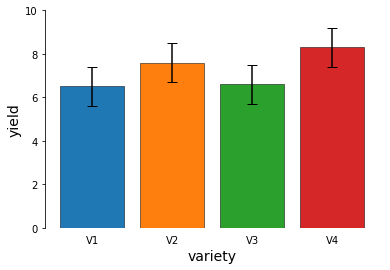

Shapiro-Wilk test for residuals
W = 0.9176, p-value = 0.2666


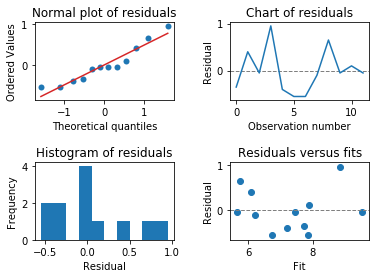

In [32]:
anova_block(df, 'variety', 'yield')

## 4. How many blocks to use?

In our example, there will always be variation between yields of plots treated alike after allowing for the block effects, and this is summarised by the residual mean square(RMS) in the ANOVA table. Its square root is the standard deviation of the residuals. A large value for RMS requires large observed differences in means between levels for a significant VR to be obtained. VR reflects the ratio of the variation in factor means to the residual variation. For a given number of levels, whether VR is significant depends on the number of blocks. The larger the number of blocks, the lower critical F-value is. A rule of thumb is to allow for at least 12 residual degrees of freedom (in field trials).

### Detection of a specified difference

A new variety will only be recommended if the benefits outweigh the extra cost of using it compared to the standard. We carry out an RBD experiment and $\delta$ is the minimum difference to be observed between a new variety to be recommended and the standard. How many blocks are necessary such that a difference of $\delta$ or more is significant at the 5% level? In other words, we want LSD to be less than $\delta$. We can only provide an estimation since the t-value depends on the number of blocks and the SED depends on the number of blocks and the RMS: 
$$LSD_{5\%} = t_{(Rdf, \thinspace 2.5\%)} \times SED = t_{(Rdf, \thinspace 2.5\%)} \times \sqrt{\frac{2 \times \sigma^2}{r}}$$
We want $t \times SED < \delta$ so $r > (2 \times t^2 \times \sigma^2)/\delta^2$

Let's suppose $\delta = 0.8$. t is around 2.0. In our previous experiments $RMS = 0.40$ and this is an estimate of $\sigma^2$. Let's calculate r.

In [44]:
#calculate number of blocks r to detect a difference between varieties of 0.8
r = 2 * 2.0 ** 2 * resid_ms / 0.8 ** 2
print('Minimum number of blocks : {}'.format(int(r)))

Minimum number of blocks : 5


This was only an approximation since with 5 blocks and 3 factor levels we have 12 degrees of freedom and the t-value is 2.179. Let's re-calculate r from the more exact t-value and round it to the next integer. We iteratively refine the number of blocks and stop when we find the same value as in the previous calculation. With our example, we find a value of 6 blocks.

In [53]:
r = 2 * t.ppf(0.975, 12) ** 2 * resid_ms / 0.8 ** 2
print('Minimum number of blocks : {}'.format(ceil(r)))

Minimum number of blocks : 6
